**Kanaya Letisia Kenza - 1301223122**

**Diva Sanjaya Wardani - 1301223167**

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [2]:
import kagglehub

dataset_path = kagglehub.dataset_download("mahmoudreda55/satellite-image-classification")
dataset_path = os.path.join(dataset_path, 'data')

print("Path to dataset files:", dataset_path)

Path to dataset files: /kaggle/input/satellite-image-classification/data


## Pre-Processing

In [3]:
categories = os.listdir(dataset_path)
print("Kategori:", categories)

Kategori: ['cloudy', 'desert', 'green_area', 'water']


In [4]:
# Inisialisasi data dan label
data = []
labels = []

# Ukuran gambar yang diinginkan
img_size = (128, 128)

In [5]:
# Preprocessing gambar
for label, category in enumerate(categories):
    category_path = os.path.join(dataset_path, category)
    for file in os.listdir(category_path):
        file_path = os.path.join(category_path, file)
        img = cv2.imread(file_path)
        if img is not None:
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalisasi
            data.append(img)
            labels.append(label)

In [6]:
# Konversi ke array NumPy
data = np.array(data)
labels = np.array(labels)

# Menyimpan data yang telah diproses
np.save('data.npy', data)
np.save('labels.npy', labels)

## Ekstraksi Fitur dengan Color Histogram

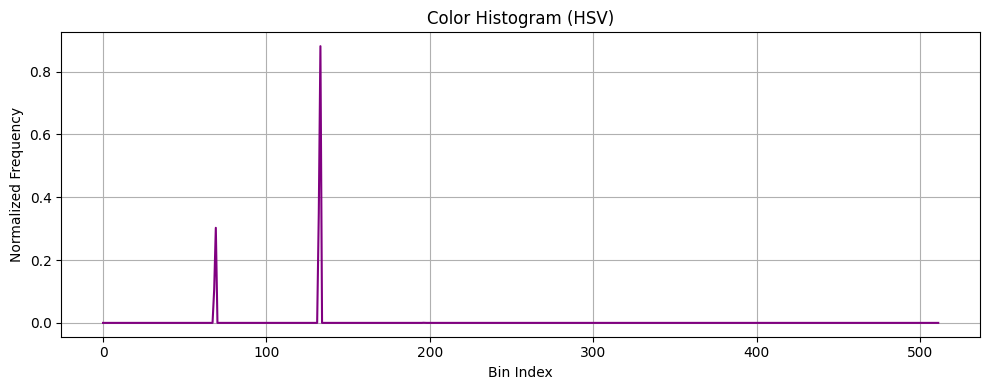

In [7]:
def extract_color_histogram(image, bins=(8, 8, 8)):
    # Konversi gambar ke ruang warna HSV
    hsv = cv2.cvtColor((image * 255).astype("uint8"), cv2.COLOR_BGR2HSV)
    # Menghitung histogram
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
                        [0, 180, 0, 256, 0, 256])
    # Normalisasi histogram
    cv2.normalize(hist, hist)
    return hist.flatten()

# Ekstraksi fitur untuk semua gambar
features = [extract_color_histogram(img) for img in data]
features = np.array(features)

# Ambil histogram dari satu gambar (contoh)
image = data[10]
hist = extract_color_histogram(image)

# Visualisasi histogram
plt.figure(figsize=(10, 4))
plt.title("Color Histogram (HSV)")
plt.xlabel("Bin Index")
plt.ylabel("Normalized Frequency")
plt.plot(hist, color='purple')  # Atau plt.bar(range(len(hist)), hist)
plt.grid(True)
plt.tight_layout()
plt.show()

## Pengembangan Model dengan Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [9]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)


In [10]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [8, 16, 32, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

rf = RandomForestClassifier()


In [11]:
pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.7 MB/s eta 0:00:00


In [12]:
from skopt import BayesSearchCV
bayes_opt = BayesSearchCV(
    estimator=rf,
    search_spaces=param_grid,
    n_iter=30,
    cv=5,
    n_jobs=-1,
    random_state=42,
    scoring='accuracy'
)

bayes_opt.fit(X_train, y_train)

y_train_pred = bayes_opt.predict(X_train)

print("Best Score:", bayes_opt.best_score_)
print("Best Parameters:", bayes_opt.best_params_)

Best Score: 0.9458263657664323
Best Parameters: OrderedDict([('max_depth', 32), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 10), ('n_estimators', 150)])


Evaluasi Model Training Random Forest:
Akurasi: 0.9740230905861457
F1-Score: 0.9740059174481158
Precision: 0.9748298903794156
Recall: 0.9740230905861457

Evaluasi Model Testing Random Forest:
Akurasi: 0.9494232475598935
F1-Score: 0.9493349696627726
Precision: 0.94998686344939
Recall: 0.9494232475598935
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       300
           1       1.00      1.00      1.00       227
           2       0.89      0.94      0.91       300
           3       0.93      0.88      0.91       300

    accuracy                           0.95      1127
   macro avg       0.95      0.95      0.95      1127
weighted avg       0.95      0.95      0.95      1127



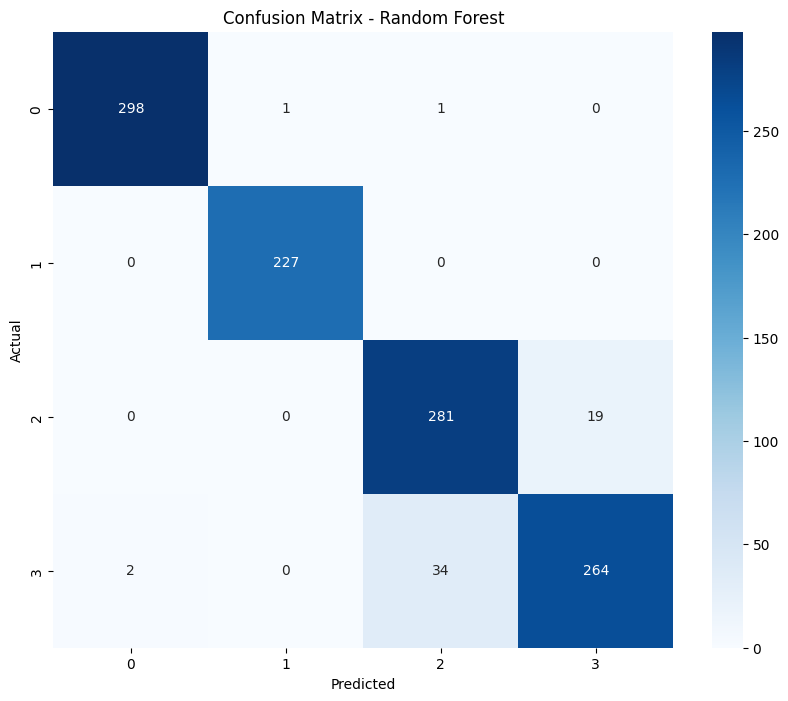

In [13]:
best_params = bayes_opt.best_params_
RF_classifier = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    min_samples_leaf=best_params['min_samples_leaf'],
    min_samples_split=best_params['min_samples_split'],
    random_state=42,
    n_jobs=-1)
RF_classifier.fit(X_train, y_train)

y_pred = RF_classifier.predict(X_test)

print("Evaluasi Model Training Random Forest:")
print("Akurasi:", accuracy_score(y_train, y_train_pred))
print("F1-Score:", f1_score(y_train, y_train_pred, average="weighted"))
print("Precision:", precision_score(y_train, y_train_pred, average="weighted"))
print("Recall:", recall_score(y_train, y_train_pred, average="weighted"))

print("")
print("Evaluasi Model Testing Random Forest:")
print("Akurasi:", accuracy_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred, average="weighted"))
print("Precision:", precision_score(y_test, y_pred, average="weighted"))
print("Recall:", recall_score(y_test, y_pred, average="weighted"))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [14]:
# Menyimpan model
import joblib
joblib.dump(RF_classifier, "bismillahpcdtubesfixlagi.pkl")

['bismillahpcdtubesfixlagi.pkl']

In [15]:
from google.colab import files

# Unduh file model .pkl
files.download('/content/bismillahpcdtubesfixlagi.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>